In [0]:
from google.colab import drive
drive.mount("/content/drive")
!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'    exercises3_aux_inp.ipynb   pixel_cnn.ipynb
 colored-mnist.pkl   exercises3.ipynb


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time

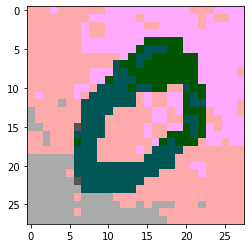

In [0]:
train, val, test = None, None, None

# load data
#with open('colored-mnist.pkl', 'rb') as f:
with open('/content/drive/My Drive/colored-mnist.pkl', 'rb') as f:
    data = pickle.load(f)
    train, _= np.split(data["train"],[50000])
    val, _ = np.split(data["train"],[1000])
    test = data["test"]
    
# show images
def show_img(sample):
    _, axs = plt.subplots(10, 10, figsize=(28, 28))
    axs = axs.flatten()
    for img, ax in zip(sample, axs):
        ax.imshow((img / 3 * 255).astype(int))
    plt.show()

# show training img
plt.imshow(train[1] / 3)
plt.show()

In [0]:
# masked conv layer for pixelcnn
class MaskedConv2d(nn.Conv2d):
    
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(in_channels, 
                                           out_channels, 
                                           kernel_size=kernel_size, 
                                           stride=stride,
                                           padding=padding)
        
        self.register_buffer('mask', self.weight.data.clone())
        _, _, H, W = self.weight.size()
        
        # mask example (3x3)
        # 1  1  1 
        # 1 1=B 0
        # 0  0  0
        
        self.mask.fill_(0)
        if mask_type == 'A':
            self.mask[:,:,0:H//2,:] = 1
            self.mask[:,:, H//2, 0:W//2] = 1
        elif mask_type == 'B':
            self.mask[:,:,0:H//2,:] = 1
            self.mask[:,:, H//2, 0:W//2 + 1] = 1
        else:
            pass
            
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)
        
# residual block for pixelcnn
class PixelCNN_ResidualBlock(nn.Module):
    
    def __init__(self, features):
        super().__init__()
        
        self.conv1 = MaskedConv2d('B', features, features//2,
                                  kernel_size=1,stride=1, padding=0)
        self.batch1 = nn.BatchNorm2d(features//2)

        self.conv2 = MaskedConv2d('B', features//2, features//2,
                                  kernel_size=3, stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(features//2)

        self.conv3 = MaskedConv2d('B', features//2, features,
                                  kernel_size=1,stride=1, padding=0)
        self.batch3 = nn.BatchNorm2d(features)
        
    def forward(self, x):
        identity = x
        out = F.relu(self.batch1(self.conv1(x)))
        out = F.relu(self.batch2(self.conv2(out)))
        out = F.relu(self.batch3(self.conv3(out)))
        out = identity + out
        return out
    


In [0]:
# https://arxiv.org/abs/1601.06759
class PixelCNN(nn.Module):

    def __init__(self, in_channels, colors_per_channel, num_features=128, aux_input=False):
        super().__init__()
        self.colors_per_channel = colors_per_channel
        self.aux_input = aux_input
        self.num_features = num_features
        
        # conv mask A
        self.conv_A1 = MaskedConv2d('A' , in_channels, self.num_features, kernel_size=7, stride=1, padding=3)
        self.batch_A1 = nn.BatchNorm2d(self.num_features)
        
        # multiple(12) residual blocks 
        self.r1 = PixelCNN_ResidualBlock(self.num_features)
        self.r2 = PixelCNN_ResidualBlock(self.num_features)
        self.r3 = PixelCNN_ResidualBlock(self.num_features)
        self.r4 = PixelCNN_ResidualBlock(self.num_features)
        self.r5 = PixelCNN_ResidualBlock(self.num_features)
        self.r6 = PixelCNN_ResidualBlock(self.num_features)
        self.r7 = PixelCNN_ResidualBlock(self.num_features)
        self.r8 = PixelCNN_ResidualBlock(self.num_features)
        self.r9 = PixelCNN_ResidualBlock(self.num_features)
        self.r10 = PixelCNN_ResidualBlock(self.num_features)
        self.r11 = PixelCNN_ResidualBlock(self.num_features)
        self.r12 = PixelCNN_ResidualBlock(self.num_features)
        
        # (ReLu) followed by 1x1 conv, mask B(2 layers)
        self.conv_B1 = MaskedConv2d('B' , self.num_features, self.num_features, kernel_size=1, stride=1, padding=0)
        self.batch_B1 = nn.BatchNorm2d(self.num_features)

        self.conv_B2 = MaskedConv2d('B' , self.num_features, self.num_features, kernel_size=1, stride=1, padding=0)
        self.batch_B2 = nn.BatchNorm2d(self.num_features)
        
        # channels
        self.conv_channels = nn.Conv2d(self.num_features, colors_per_channel * 3, kernel_size=1, stride=1, padding=0)
        self.batch_channels = nn.BatchNorm2d(self.num_features)
        
    def forward(self, x):
        batch_size = x.size()[0]
        
        # conv mask A
        out = F.relu(self.batch_A1(self.conv_A1(x)))
        
        # multiple(12) residual blocks 
        out = self.r1(out)
        out = self.r2(out)
        out = self.r3(out)
        out = self.r4(out)
        out = self.r5(out)
        out = self.r6(out)
        out = self.r7(out)
        out = self.r8(out)
        out = self.r9(out)
        out = self.r10(out)
        out = self.r11(out)
        out = self.r12(out)
        
        # (ReLu) followed by 1x1 conv, mask B(2 layers)
        out = F.relu(self.batch_B1(self.conv_B1(out)))
        out = F.relu(self.batch_B2(self.conv_B2(out)))

        # channel outputs
        channels = F.relu(self.conv_channels(out))
        channels = channels.view(batch_size, 3, self.colors_per_channel,28,28)
        
        # auxiliary input for MADE
        if self.aux_input:
          channels = channels.view(batch_size, 3*self.colors_per_channel,28,28)
          return channels

        channels = channels.permute(0,1,3,4,2)
        return channels

In [0]:
class MADE_MaskedLinear(nn.Linear):
    
    def __init__(self, layer_type, in_features, out_features, prev_l_mk, l_mk):
        super().__init__(in_features, out_features)
        
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(0)
        
        for i in range(in_features):
            for j in range(out_features):
                
                if layer_type == "V":
                    if l_mk[j] > prev_l_mk[i]:
                        self.mask[j,i] = 1
                else:
                    if l_mk[j] >= prev_l_mk[i]:
                        self.mask[j,i] = 1
        
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MADE_MaskedLinear, self).forward(x)
        
# MADE https://arxiv.org/abs/1502.03509
class MADE(nn.Module):
    
    def __init__(self, in_features, D, L, L_units, d_mk, v_mk):
        super().__init__()
        
        # init m_l_(k) for every layer
        self.tmp = torch.tensor(np.ones(D-1)/(D-1))
        self.tmp2 = self.tmp.repeat(L*L_units,1)
        self.mks = torch.multinomial(self.tmp2, 1).view(L,-1)
        
        # mask every layer
        # W
        W_layers = []
        for i in range(0, L):
            if i == 0:
                W_layers.append(MADE_MaskedLinear("W",in_features,L_units,d_mk,self.mks[0]))
            else:
                W_layers.append(MADE_MaskedLinear("W",L_units,L_units,self.mks[i-1],self.mks[i]))

            W_layers.append(nn.BatchNorm1d(L_units))
            W_layers.append(nn.ReLU())

                
        self.W_layers = nn.Sequential(*W_layers)

        # V
        self.V_layer = MADE_MaskedLinear("V", L_units, v_mk.shape[0], self.mks[-1], v_mk)
        
    def forward(self, x):
        
        out = self.W_layers(x)
        out = self.V_layer(out)
        return out                 

In [0]:
# combine MADE and PixelCNN - use PixelCnn output as an auxiliary input for MADE
class MADE_PixelCNN(nn.Module):
    
    def __init__(self, pixelcnn_features=128, aux_input=12):
        super().__init__()
        self.pixelcnn_features = pixelcnn_features
        self.aux_input = aux_input

        # use D = 4 (instead of 3) so that aux input will be used for every MADE conditional probability

        # 0 -> aux input
        # 1 -> first color channel
        # 2 -> second color channel
        # 3 -> third color channel

        self.D = 4

        # MADE input | aux + image color channels
        self.d_mk = torch.zeros(15).long()
        self.d_mk[-3] = 1
        self.d_mk[-2] = 2
        self.d_mk[-1] = 3

        # MADE output | 3x4 color probabilities
        self.v_mk = torch.tensor([1,1,1,1,2,2,2,2,3,3,3,3]).long()
        
        self.pixel_cnn = PixelCNN(3, 4, num_features = pixelcnn_features, aux_input=True)
        self.made = MADE(15, self.D , 3, 256, self.d_mk, self.v_mk)
        
    def forward(self, x):
        batch_size = x.size()[0]


        out = self.pixel_cnn(x)

        # stack aux input with color channels of x
        # shape N,15,28,28
        out = torch.cat((out, x) ,dim=1)
  
        out = out.permute(0,2,3,1)
        out = out.contiguous().view(-1, 15)
        out = self.made(out)
        return out

In [0]:
#setup
torch.cuda.empty_cache()

batch_size = 128
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val, batch_size=batch_size)

model = MADE_PixelCNN(pixelcnn_features=128)
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

training_loss = []
val_loss = []

#training
for epoch in range(22):
    
    print(f"**** EPOCH {epoch} ****")
    start_time = time.time()

    model.train(True)
    training_loss_tmp = []
    for i, y in enumerate(train_dl):
        
        y = y.permute(0,3,1,2).type('torch.FloatTensor').cuda()
        
        out = model(y)
        out = out.contiguous()
        out = out.view(-1, 4)
        target = y.data.permute(0,2,3,1).contiguous().view(-1).long()
        
        
        loss = loss_fn(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss_tmp.append(loss.cpu().detach().numpy())
    
    # val loss
    val_tmp = []
    for i, y in enumerate(val_dl):
    
        y = y.permute(0,3,1,2).type('torch.FloatTensor').cuda()

        out = model(y)
        out = out.contiguous()
        out = out.view(-1, 4)
        target = y.data.permute(0,2,3,1).contiguous().view(-1).long()


        loss = loss_fn(out, target)
        val_tmp.append(loss.cpu().detach().numpy())
    
    # mean train & val loss
    training_loss.append(np.mean(np.array(training_loss_tmp)))
    val_loss.append(np.mean(np.array(val_tmp)))
    
    print(f'Train loss: {np.mean(np.array(training_loss_tmp))} | Val loss: {np.mean(np.array(val_tmp))}')
          
    # time
    end_time = time.time()
    print(f'time elapsed: {end_time - start_time} \n******************')
    

**** EPOCH 0 ****
Train loss: 0.26347053050994873 | Val loss: 0.12348022311925888
time elapsed: 108.23963022232056 
******************
**** EPOCH 1 ****
Train loss: 0.10379534959793091 | Val loss: 0.08882839977741241
time elapsed: 108.26684832572937 
******************
**** EPOCH 2 ****
Train loss: 0.08009717613458633 | Val loss: 0.07071065902709961
time elapsed: 108.26502799987793 
******************
**** EPOCH 3 ****
Train loss: 0.06345918774604797 | Val loss: 0.05865767225623131
time elapsed: 108.26800060272217 
******************
**** EPOCH 4 ****
Train loss: 0.053869348019361496 | Val loss: 0.05099860206246376
time elapsed: 108.26470923423767 
******************
**** EPOCH 5 ****
Train loss: 0.04901629313826561 | Val loss: 0.047531574964523315
time elapsed: 108.2513678073883 
******************
**** EPOCH 6 ****
Train loss: 0.04621947184205055 | Val loss: 0.0453861802816391
time elapsed: 108.25932312011719 
******************
**** EPOCH 7 ****
Train loss: 0.044865287840366364 | Va

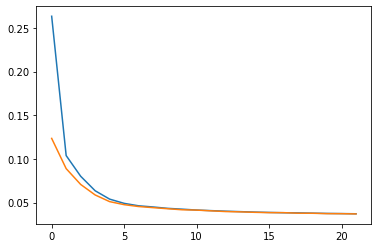

In [0]:
# plot training and val loss
plt.plot(range(len(training_loss)), training_loss)
plt.plot(range(len(val_loss)), val_loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


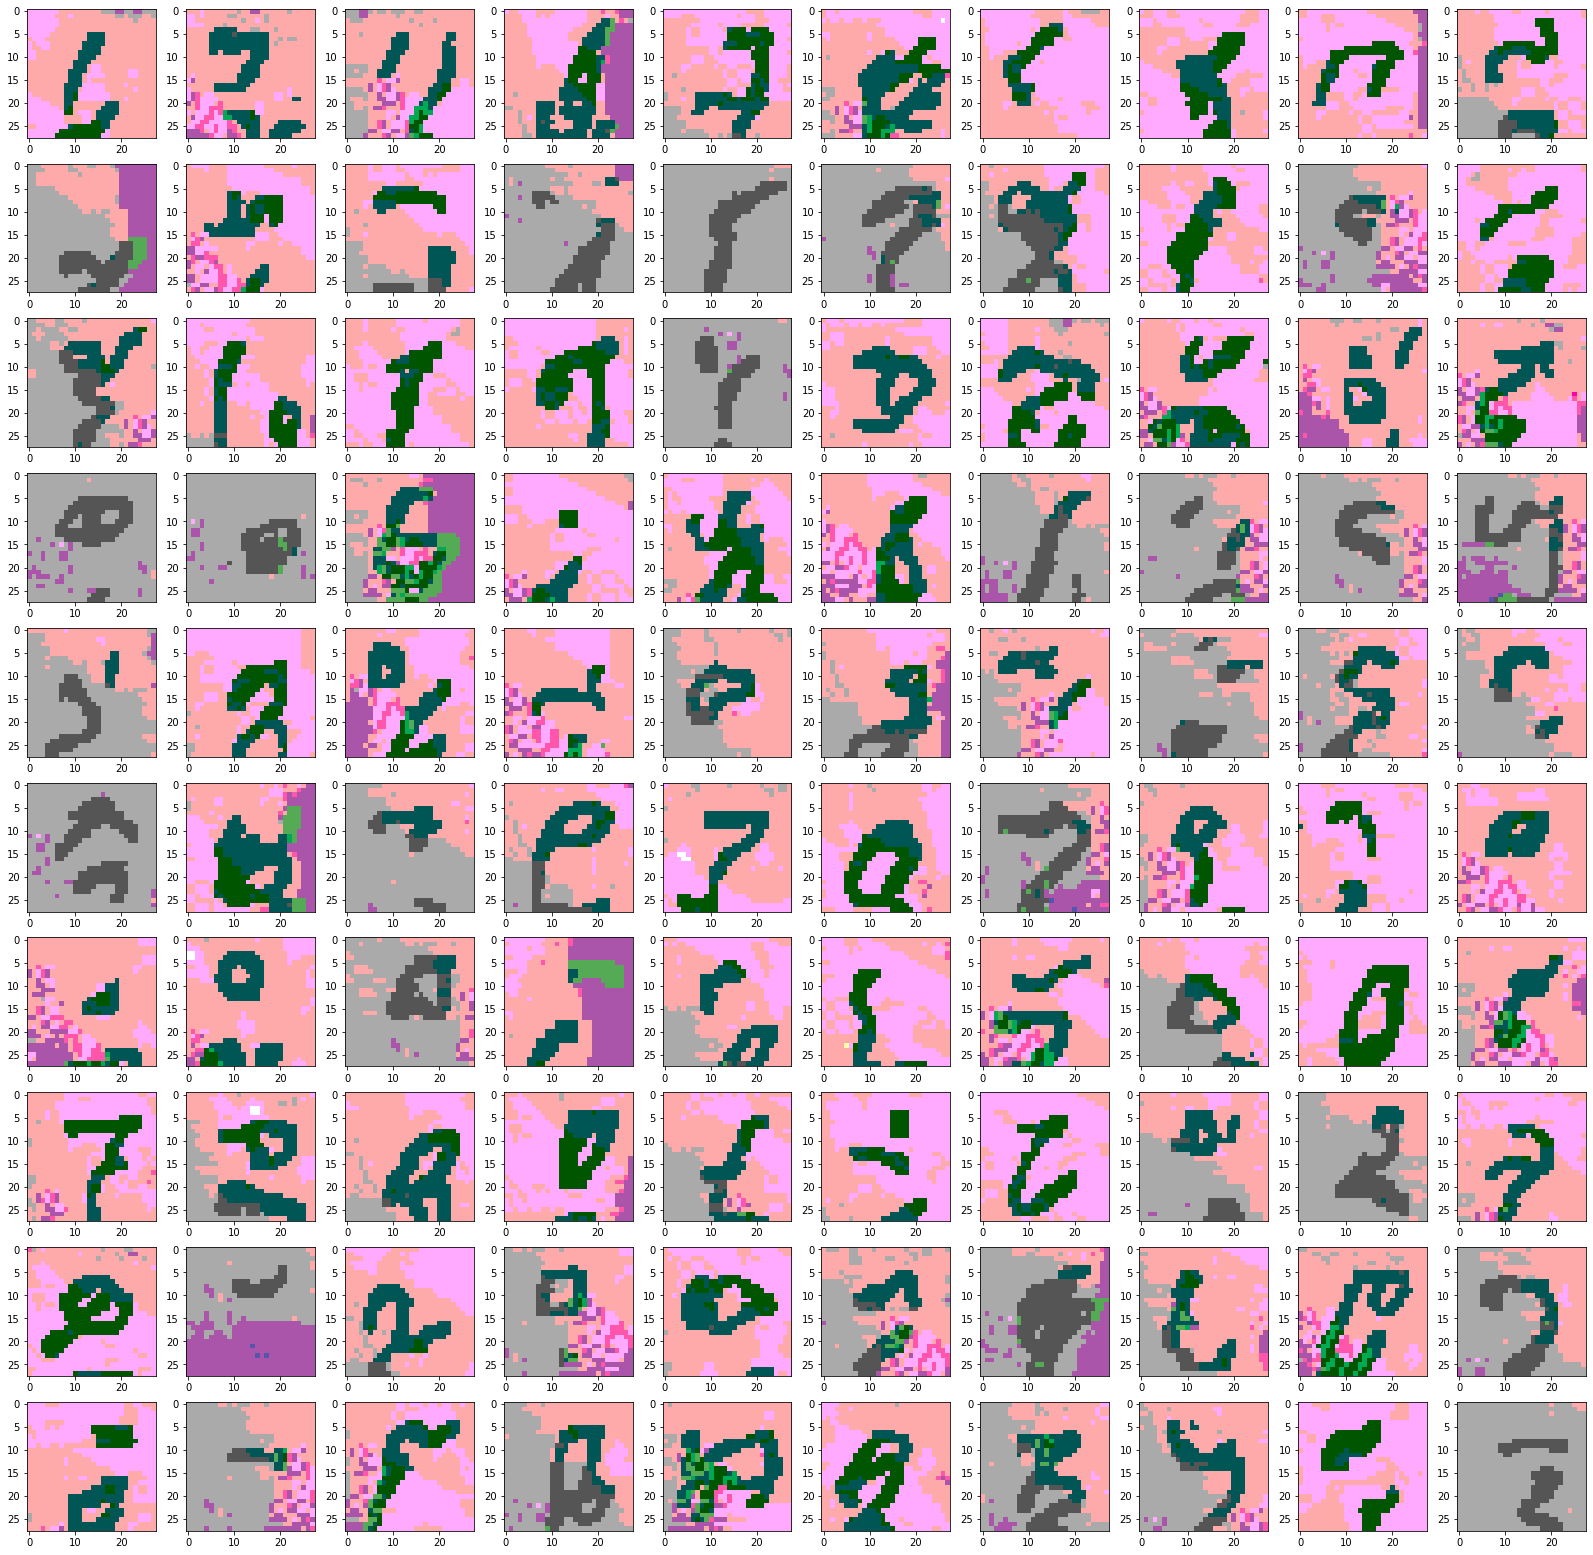

In [0]:
# sample images
torch.cuda.empty_cache()
images = 100
sample = torch.zeros(images, 3, 28, 28).cuda()
model.train(False)
for i in range(28):
    for j in range(28):
        for c in range(3):
        
            out = model(sample)
            out = out.contiguous().view(-1,28,28,3,4)
            out = F.softmax(out, dim=4)
            
            probs = out[:, i, j, c]
            pixel = torch.multinomial(probs, 1)
            sample[:, c, i, j] = pixel[:,0]
            
    print(i)
            
sample = sample.permute(0,2,3,1).cpu().detach().numpy()
show_img(sample)

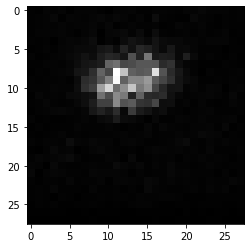

In [0]:
# show receptive field of the model

loss_fn = nn.CrossEntropyLoss()
rnd_img = Variable(torch.round((torch.rand(1,3,28,28)*3)),requires_grad=True)
model = MADE_PixelCNN()


out = model(rnd_img)

out = out.contiguous().view(-1,28,28,3,4)
out = F.softmax(out, dim=4)

pixel_distr = out[0,14,14,:]
target = torch.tensor([1,2,3])

loss = loss_fn(pixel_distr,target)
loss.backward()

receptive_field = rnd_img.grad.data[0].permute(1,2,0).detach().numpy()
receptive_field = np.abs(receptive_field).max(axis=2)
plt.imshow(receptive_field,cmap='gray')